<img src='ihe_logo.png' width="250" height="300"></img>

<table style="width: 100%">
<tr>
  <td><center><font size="8">M027-2425T05</font></center></td>
</tr>
<tr>
  <td><center><font size="8">Water Transport and Distribution - Optimisation</font></center></td>
</tr>
<tr>
   <td><center><font size="5">February 2025</font><center></td>
</tr>
<tr>  
   <td><center><font size="5">Automatic calibration of a Water Distribution Network</font></center></td>
</tr>
<tr>
   <td><center><font size="2">By: Leonardo Alfonso, Associate Professor in Hydroinformatics</font></center></td>
</tr>
       
</table>

# Learning objective
To apply the concepts of optimisation to the calibration of a Water Distribution Network model in EPANET.

# Background Information
Accurate hydraulic models are crucial for effective water distribution system management. Calibration adjusts model parameters (e.g., pipe roughness) to match observed field data (e.g., pressures, flows). This ensures the model accurately predicts system behavior under various conditions.

<b>Importance of Calibration</b>:

 - Improved decision-making for operation and maintenance.
 - Accurate prediction of pressure and flow under different scenarios (e.g., demand changes, pipe breaks).
 - Optimized design of system expansions and upgrades.

<b>Manual vs. Automated Calibration:</b>

Manual calibration is time-consuming and subjective. Automated calibration using optimization algorithms provides 
a systematic and efficient approach to find optimal parameter values.

# Material
- The EPANET file of the system is given (`network_original_G1.inp`) (acknowledgments to Dr. Valentina Marsili).
- A Comma Separated File (`observed_pressures.csv`) containing the elements that can be changed and their original status. Its content is the following:
<center><img src='network.png' width="800" height="800"></img></center>
<center><img src='observed_pressures.png' width="350" height="350"></img></center>

# Tools
For both, we will install the libraries WNTR and PYMOO, described below.

### WNTR
The <a href="https://wntr.readthedocs.io/en/stable/">Water Network Tool for Resilience (WNTR) </a> is a Python package designed by Sandia National Laboratories and the US Environmental Protection Agency, to simulate and analyze resilience of water distribution networks. The software includes capability to, among others:

- Modify network structure and operations
- Add response/repair strategies
- Simulate pressure dependent demand and demand-driven hydraulics
- Simulate water quality

We will use WNTR for:
- automatically changing the roughness coefficients to all the pipes in the EPANET model
- automatically run the model(s)
- automatically read the pressures at the same nodes where we have the observations (Nodes 4, 8, 10 and 11). These results will be used to evaluate the error between modelled and observed pressures, which we want to minimize.

### PYMOO
The <a href="https://pymoo.org/index.html">Multi-objective Optimization in Python PYMOO </a> is a Python library that offers a collection of interfaces, algorithms and visualisatoin tools for optimisation.

We will use PYMOO for:
- Minimizing the error between modelled and observed pressures by changing the roughness coefficients of all pipes.
- display the optimal set of roughness coefficients, for which modelled pressures fit best the observations.

WNTR and PYMOO are libraries that need to be installed before they can be used. To this end, uncomment the following lines (to be run only one time; after that, these lines can be commented again)


# Approach

The idea is to find the roughness coefficient value for each pipe, such that the difference between observed and modelled pressures is the minimum. As we have presures every hour and in different nodes, one way to evaluate this error is to find the sum of the pressure differences for all times (the blue arrows in the figure below, for node 4). We can come up with an overal value of error by summing up these distances for nodes 8, 10 and 11. The ideal value would be 0.0.

<center><img src='errors.png'></img></center>

# Steps

1. Install the Python packages `WNTR` and `PYMOO` if needed. Import the libraries.
2. Load the hydraulic model using `PYMOO`
3. Read the observed pressures from the file `observed_pressures.csv`
4. Change the roughness coefficient of pipes
5. Run the model
6. Read the modelled pressures
7. Evaluate the difference between modelled and observed pressures

To implement steps 4, 5 and 6 the `PYMOO` library is used, and this requires advanced knowledge of Python. 

# Action
Before running the code, are you able to identify the lines where the seven steps above are happenning?

In [ ]:
# uncomment the following two lines to install the needed libraries in your laptop; This needs to be done only once:

# %pip install --user wntr
# %pip install --user pymoo

In [ ]:
import wntr
import numpy as np
import pandas as pd
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.lhs import LHS
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.termination.default import DefaultSingleObjectiveTermination
import matplotlib.pyplot as plt

# Load the hydraulic model
def load_model(filename):
    return wntr.network.WaterNetworkModel(filename)

# Load observed pressures from CSV file
def load_observed_pressures(filename):
    df = pd.read_csv(filename, index_col=0, delimiter=',')
    df.index = pd.to_datetime(df.index, format='%H:%M').hour + pd.to_datetime(df.index, format='%H:%M').minute / 60  # Convert time to fractional hours
    return df

# Define optimization problem
class HydraulicCalibration(Problem):
    def __init__(self, model, observed_pressures):
        self.model = model
        self.observed_pressures = observed_pressures
        self.pipes = list(model.pipe_name_list)
        super().__init__(n_var=len(self.pipes), n_obj=1, n_constr=0,
                         xl=0.1, xu=2.0, type_var=float)
    
    def _evaluate(self, X, out, *args, **kwargs):
        errors = []
        modelled_pressures_list = []
        for i in range(X.shape[0]):
            # Set roughness coefficients
            for j, pipe in enumerate(self.pipes):
                self.model.get_link(pipe).roughness = X[i, j]
            
            # Run simulation
            sim = wntr.sim.EpanetSimulator(self.model)
            results = sim.run_sim()
            
            # Compute error
            modelled_pressures = results.node['pressure'][self.observed_pressures.columns]
            error = np.abs(modelled_pressures.values - self.observed_pressures.values).sum()
 #           print(error)
            errors.append(error)
            modelled_pressures_list.append(modelled_pressures)
        out["F"] = np.array(errors).reshape(-1, 1)
        self.modelled_pressures_list = modelled_pressures_list

# Load model and observed pressures
model = load_model("network_original_G1.inp")
observed_pressures = load_observed_pressures("observed_pressures.csv")

# Define problem
problem = HydraulicCalibration(model, observed_pressures)

# Configure and run NSGA2 optimization
algorithm = GA(
    pop_size=10,  # Reduced population for faster execution
    sampling=LHS(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

#termination = DefaultMultiObjectiveTermination()

termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=100,
    n_max_evals=1000
)

result = minimize(problem, algorithm, termination, verbose=True)


# Visualising the results
The result of the optimization process is the set of optimal roughness coefficients for each pipe in the network. This is stored in the `result` variable (Python object), along with other information about the optimization process.

,Pipe,Optimized Roughness
0,2,1.004769
1,3,1.977791
2,4,1.290669
3,5,1.805621
4,6,1.955613
5,7,1.337550
6,8,0.801523
7,9,0.662867
8,10,1.999340
9,11,1.692017


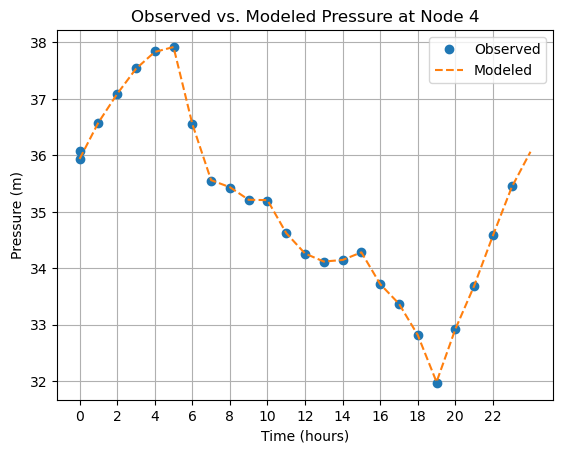

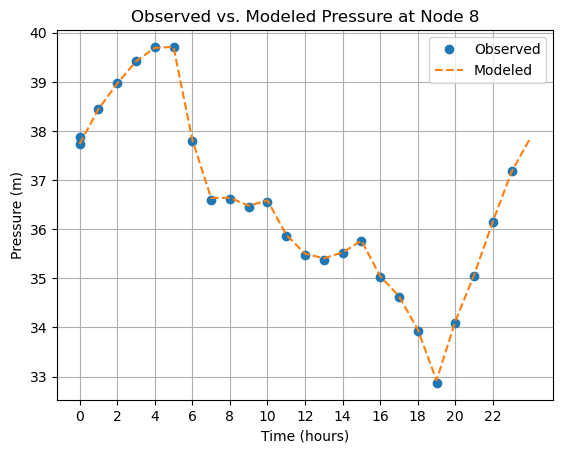

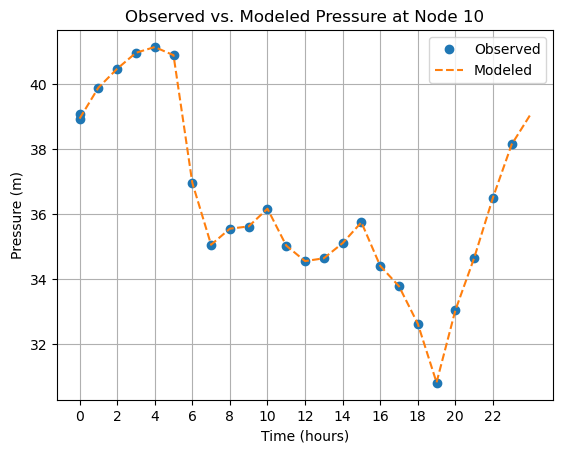

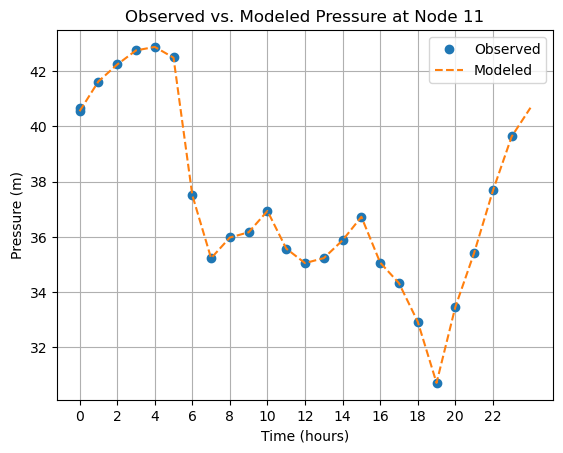

In [28]:
# Extract best solution
best_index = np.argmin(result.F)
best_solution = result.X

# Display optimized roughness coefficients
optimized_roughness = pd.DataFrame({'Pipe': problem.pipes, 'Optimized Roughness': best_solution})
display(optimized_roughness)

# Plot observed vs. modeled pressures for best solution
best_modelled_pressures = problem.modelled_pressures_list[best_index]

for node in observed_pressures.columns:
    plt.figure()
    plt.plot(observed_pressures.index, observed_pressures[node], label="Observed", marker='o', linestyle='None')
    plt.plot(best_modelled_pressures.index/3600, best_modelled_pressures[node], label="Modeled", linestyle='--')
    plt.xlabel("Time (hours)")
    plt.ylabel("Pressure (m)")
    plt.xticks(np.arange(0, 24, 2))  # Set x-axis ticks every 2 hours
    plt.title(f"Observed vs. Modeled Pressure at Node {node}")
    plt.legend()
    plt.grid()
    plt.show()


# Visualization of optimal roughness per pipe

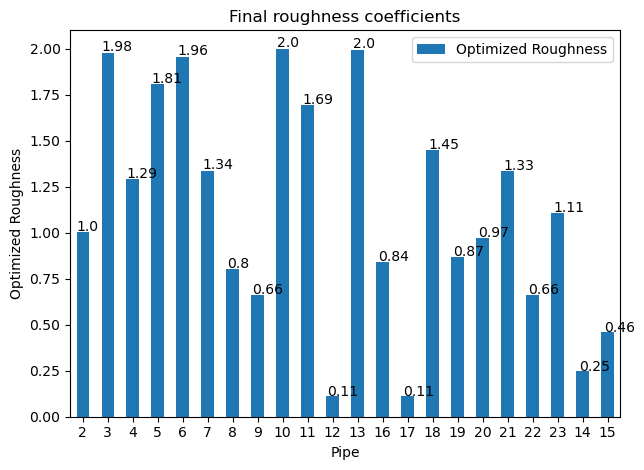

In [29]:
import matplotlib.pyplot as plt

# Set 'Pipe' column as index
optimized_roughness = optimized_roughness.set_index('Pipe')

# Plotting
ax = optimized_roughness.plot(kind='bar', title='Final roughness coefficients', rot=0)

# Customizations
plt.xlabel("Pipe")
plt.ylabel("Optimized Roughness")
plt.tight_layout()

# Display values on top of bars
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005)) #Round to 2 decimals

plt.show()

# Questions

1. Is this a single or a multi-objective optimization problem?
2. What is the objective function?
3. What are the decision variables?
4. What are the constraints of the problem?
5. After looking at the results, what can you tell about the network?